# Elasticity solver examples

Author(s): Jukka Aho <jukka.aho@kapsi.fi>

In [1]:
# These are internal module functions and not intended to use like this.
using JuliaFEM.elasticity_solver
using JuliaFEM.xdmf
using JuliaFEM.abaqus_reader
using Logging
Logging.configure(level=DEBUG)


Use "Dict{Any,Any}(a=>b, ...)" instead.

Use "Dict{Any,Any}(a=>b, ...)" instead.


Logger(root,DEBUG,Pipe(open, 0 bytes waiting),root)

In [3]:
using LightXML

## 2d beam with linear elements

In [2]:
function one_elem_fixture()
  X = [0.0 0.0; 10.0 0.0; 10.0 1.0; 0.0 1.0]'
  elmap = [1; 2; 3; 4]
  nodalloads = [0 0; 0 0; 0 -2; 0 0]'
  dirichletbc = [0 0; NaN NaN; NaN NaN; 0 0]'

  E = 90
  nu = 0.25
  mu = E/(2*(1+nu))
  la = E*nu/((1+nu)*(1-2*nu))
  la = 2*la*mu/(la + 2*mu)

  la = la*ones(1, 4)
  mu = mu*ones(1, 4)
  u = zeros(2, 4)
  du = zeros(2, 4)

  N(xi) = [
      (1-xi[1])*(1-xi[2])/4
      (1+xi[1])*(1-xi[2])/4
      (1+xi[1])*(1+xi[2])/4
      (1-xi[1])*(1+xi[2])/4
    ]

  dNdξ(ξ) = [-(1-ξ[2])/4.0    -(1-ξ[1])/4.0
              (1-ξ[2])/4.0    -(1+ξ[1])/4.0
              (1+ξ[2])/4.0     (1+ξ[1])/4.0
             -(1+ξ[2])/4.0     (1-ξ[1])/4.0]

  ipoints = 1/sqrt(3)*[-1 -1; 1 -1; 1 1; -1 1]
  iweights = [1 1 1 1]

    return (X, u, du, elmap, nodalloads, dirichletbc,
     la, mu, N, dNdξ, ipoints, iweights)
end

(X, u, du, elmap, nodalloads, dirichletbc,
 la, mu, N, dNdξ, ipoints, iweights) = one_elem_fixture()
    
for i=1:10
    JuliaFEM.elasticity_solver.solve_elasticity_increment!(X, u, du, elmap, nodalloads, dirichletbc,
    la, mu, N, dNdξ, ipoints, iweights)
    u += du
    if norm(du) < 1.0e-9
        println("Converged")
        break
    end
end

u

Converged


2x4 Array{Float64,2}:
 0.0  -0.399145  -0.0722858  0.0
 0.0  -2.17799   -2.22224    0.0

In [3]:
u3d = [u; 0 0 0 0] # extend to 3d vector field
X3d = [X; 0 0 0 0]
elmap2 = [0x5; elmap]'';

In [4]:
xdoc, model = JuliaFEM.xdmf.xdmf_new_model()
temporal_collection = JuliaFEM.xdmf.xdmf_new_temporal_collection(model)
grid = JuliaFEM.xdmf.xdmf_new_grid(temporal_collection; time=0)
JuliaFEM.xdmf.xdmf_new_mesh(grid, X3d, elmap2)
JuliaFEM.xdmf.xdmf_new_field(grid, "Displacement", "nodes", u3d)
print(xdoc)
JuliaFEM.xdmf.xdmf_save_model(xdoc, "/tmp/foo.xmf")

<?xml version="1.0" encoding="utf-8"?>
<Xdmf xmlns:xi="http://www.w3.org/2001/XInclude" Version="2.1">
  <Domain>
    <Grid CollectionType="Temporal" GridType="Collection" Name="Collection">
      <Geometry Type="None"/>
      <Topology Dimensions="0" Type="NoTopology"/>
      <Grid Name="Grid">
        <Time Value="0"/>
        <Geometry Type="XYZ">
          <DataItem DataType="Float" Dimensions="12" Format="XML" Precision="4">0.0 0.0 0.0 10.0 0.0 0.0 10.0 1.0 0.0 0.0 1.0 0.0</DataItem>
        </Geometry>
        <Topology Dimensions="1" Type="Mixed">
          <DataItem DataType="Int" Dimensions="5" Format="XML" Precision="4">5 0 1 2 3</DataItem>
        </Topology>
        <Attribute Center="Node" Name="Displacement" Type="Vector">
          <DataItem DataType="Float" Dimensions="12" Format="XML" Precision="4">0.0 0.0 0.0 -0.3991450609547433 -2.17798923170735 0.0 -0.07228582695592455 -2.222244754401764 0.0 0.0 0.0 0.0</DataItem>
        </Attribute>
      </Grid>
    </Grid>
  </D

1015

 in depwarn at /Applications/Julia-0.4.0-dev-539c818c4e.app/Contents/Resources/julia/lib/julia/sys.dylib
 in int at deprecated.jl:49
 in save_file at /Users/jukka/.julia/v0.4/LightXML/src/document.jl:108
 in xdmf_save_model at /Users/jukka/.julia/v0.4/JuliaFEM/src/xdmf.jl:106
 in include_string at loading.jl:99
 in execute_request_0x535c5df2 at /Users/jukka/.julia/v0.4/IJulia/src/execute_request.jl:157
 in eventloop at /Users/jukka/.julia/v0.4/IJulia/src/IJulia.jl:123
 in anonymous at task.jl:365
while loading In[4], in expression starting on line 7


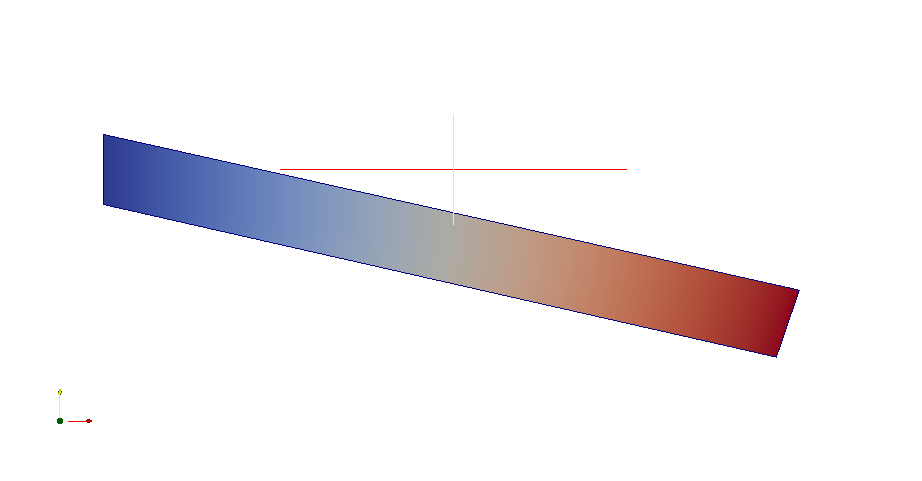

In [25]:
using PyCall
@pyimport IPython.display as d
d.Image("/tmp/displacement.png")

## 3d beam with quadratic elements

In [4]:
fid = open("../geometry/3d_beam/palkki.inp")
model = JuliaFEM.abaqus_reader.parse_abaqus(fid)
close(fid)
model

27-Jun 23:44:05:INFO:root:Registered handlers: Any["ELEMENT","NODE","NSET"]
 in depwarn at /Applications/Julia-0.4.0-dev-539c818c4e.app/Contents/Resources/julia/lib/julia/sys.dylib
 in beginswith at deprecated.jl:30
 in parse_abaqus at /Users/jukka/.julia/v0.4/JuliaFEM/src/abaqus_reader.jl:113
 in include_string at loading.jl:99
 in execute_request_0x535c5df2 at /Users/jukka/.julia/v0.4/IJulia/src/execute_request.jl:157
 in eventloop at /Users/jukka/.julia/v0.4/IJulia/src/IJulia.jl:123
 in anonymous at task.jl:365
while loading In[4], in expression starting on line 2
 in depwarn at /Applications/Julia-0.4.0-dev-539c818c4e.app/Contents/Resources/julia/lib/julia/sys.dylib
 in beginswith at deprecated.jl:30
 in parse_abaqus at /Users/jukka/.julia/v0.4/JuliaFEM/src/abaqus_reader.jl:113
 in include_string at loading.jl:99
 in execute_request_0x535c5df2 at /Users/jukka/.julia/v0.4/IJulia/src/execute_request.jl:157
 in eventloop at /Users/jukka/.julia/v0.4/IJulia/src/IJulia.jl:123
 in anonymo

Dict{Any,Any} with 4 entries:
  "nodes"    => Dict{Any,Any}(288=>[97.5,7.5,10.0],11=>[92.5,2.5,5.0],134=>[45.…
  "elements" => Dict{Any,Any}(68=>[71,144,149,198,51,150,57,43,50,214],2=>[204,…
  "elsets"   => Dict{Any,Any}("Body1"=>[1,2,3,4,5,6,7,8,9,10  …  111,112,113,11…
  "nsets"    => Dict{Any,Any}("LOAD"=>[82,84,87,179,197,246,249,256,257],"SUPPO…

In [5]:
nnodes = length(model["nodes"])
nelements = length(model["elements"])
dim = 3
E = 90
nu = 0.25
mu = E/(2*(1+nu))
la = E*nu/((1+nu)*(1-2*nu))

X = zeros(dim, nnodes)
u = zeros(dim, nnodes)
du = zeros(dim, nnodes)
elmap = zeros(Int, 10, nelements)
nodalloads = zeros(3, nnodes)
dirichletbc = NaN*ones(3, nnodes)
la = la*ones(1, nnodes)
mu = mu*ones(1, nnodes)

# calculate permutation which maps node ids to matrix indices
perm = Dict()
for (j, k) in enumerate(keys(model["nodes"]))
    perm[k] = j
end

for j=1:nnodes
    #X[:,j] = model["nodes"][perm[j]]
    X[:,j] = model["nodes"][j]
end

for (j, k) in enumerate(keys(model["elements"]))
    #node_ids = model["elements"][j]
    elmap[:,j] = model["elements"][j]
    #for l=1:10
    #    elmap[l, j] = perm[node_ids[l]]
    #end
end

elmap

10x120 Array{Int64,2}:
 243  204  259  145   96   96  236  285  …  217   69  154  179  203   96  259
 240  199   70  175   88  101   88  179     216  144  114   91  204  267  199
 191  175   69  199  236  164  285  178     278   78  278  178  259   95  204
 117  130  130  130  178   97  178   83     155   71  218   83  199   97  130
 245  207  265  177  141  102  290   12     219  146   20  181  206  268   39
 242  208   72  208  290  171  289  182  …  282  152  280  180  263  272  207
 244  209    5  202  291    9  287   11      33   79   32  182  262   98  263
   1    3    6  174    7   99  237   13     224   74  223   14  205   99    6
   2    4  132  176    8  103    8   14     225   51  284   93  207   24    4
 196  176  134    4  237   10   11   15      17   80  283   15   39  100    3

In [6]:
# Handle dirichlet boundaries on SUPPORT
for j in model["nsets"]["SUPPORT"]
    #dirichletbc[perm[j]] = 0.0
    dirichletbc[j] = 0.0
end
dirichletbc

3x298 Array{Float64,2}:
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN

Shape functions and integration points

In [7]:
Ntet(xi) = [(xi[1] + xi[2] + xi[3] - 1)*(2*xi[1] + 2*xi[2] + 2*xi[3] - 1)
                                        -xi[1]*(-2*xi[1] + 1)
                                        -xi[2]*(-2*xi[2] + 1)
                                        -xi[3]*(-2*xi[3] + 1)
                         4*xi[1]*(-xi[1] - xi[2] - xi[3] + 1)
                                                4*xi[1]*xi[2]
                         4*xi[2]*(-xi[1] - xi[2] - xi[3] + 1)
                                                4*xi[1]*xi[3]
                                                4*xi[2]*xi[3]
                         4*xi[3]*(-xi[1] - xi[2] - xi[3] + 1)]

dNtet(xi) = [
    4*xi[1] + 4*xi[2] + 4*xi[3] - 3   4*xi[1] + 4*xi[2] + 4*xi[3] - 3   4*xi[1] + 4*xi[2] + 4*xi[3] - 3
                     4*xi[1] - 1                                0                                0
                               0                      4*xi[2] - 1                                0
                               0                                0                      4*xi[3] - 1
-8*xi[1] - 4*xi[2] - 4*xi[3] + 4                         -4*xi[1]                         -4*xi[1]
                         4*xi[2]                          4*xi[1]                                0
                        -4*xi[2]  -4*xi[1] - 8*xi[2] - 4*xi[3] + 4                         -4*xi[2]
                         4*xi[3]                                0                          4*xi[1]
                               0                          4*xi[3]                          4*xi[2]
                        -4*xi[3]                         -4*xi[3] -4*xi[1] - 4*xi[2] - 8*xi[3] + 4]

dNtet (generic function with 1 method)

In [8]:
sum(Ntet([0, 1, 1]))

1

In [9]:
# from code aster documentation
a = 1/20*(5-sqrt(5))
b = 1/20*(5+3*sqrt(5))
ipoints = [a a a; a a b; a b a; b a a]
iweights = 1/24*[1 1 1 1]

1x4 Array{Float64,2}:
 0.0416667  0.0416667  0.0416667  0.0416667

Add point force to LOAD nodeset

In [10]:
model["nsets"]["LOAD"]

9-element Array{Int64,1}:
  82
  84
  87
 179
 197
 246
 249
 256
 257

In [11]:
#nodalloads[3, perm[82]] = -0.06
nodalloads[3, 82] = -50.0
println(model["nodes"][82])

[100.0,10.0,0.0]


In [12]:
u = zeros(dim, nnodes)
du = zeros(dim, nnodes)

for i=1:10
    JuliaFEM.elasticity_solver.solve_elasticity_increment!(X, u, du, elmap, nodalloads, dirichletbc,
    la, mu, Ntet, dNtet, ipoints, iweights)
    u += du
    println("iteration $i, norm = $(norm(du))")
    if norm(du) < 1.0e-9
        println("Converged")
        break
    end
end
u

iteration 1, norm = 93.13879357262775
iteration 2, norm = 14.241640589907869
iteration 3, norm = 2.3999534862146534
iteration 4, norm = 0.8191634532858331
iteration 5, norm = 0.08574651168344295
iteration 6, norm = 0.00032306479346201524
iteration 7, norm = 8.052462405199464e-9
iteration 8, norm = 3.0878906643174355e-14


3x298 Array{Float64,2}:
 -0.0479657  -0.0483971  -0.0497284  …  -0.0155295  -0.0150513  -0.0462958
 -0.474054   -0.418817   -0.254176      -0.229641   -0.283098   -0.694379 
  0.232677    0.198051    0.0948355      0.128246    0.162511    0.371043 

Converged


In [13]:
maximum(abs(u))

15.449170689704438

In [14]:
size(elmap)

(10,120)

In [15]:
nelements

120

In [16]:
elcodes = 0x0026*ones(Int, nelements)
elmap2 = [elcodes'
          elmap]

11x120 Array{Int64,2}:
  38   38   38   38   38   38   38   38  …   38   38   38   38   38   38   38
 243  204  259  145   96   96  236  285     217   69  154  179  203   96  259
 240  199   70  175   88  101   88  179     216  144  114   91  204  267  199
 191  175   69  199  236  164  285  178     278   78  278  178  259   95  204
 117  130  130  130  178   97  178   83     155   71  218   83  199   97  130
 245  207  265  177  141  102  290   12  …  219  146   20  181  206  268   39
 242  208   72  208  290  171  289  182     282  152  280  180  263  272  207
 244  209    5  202  291    9  287   11      33   79   32  182  262   98  263
   1    3    6  174    7   99  237   13     224   74  223   14  205   99    6
   2    4  132  176    8  103    8   14     225   51  284   93  207   24    4
 196  176  134    4  237   10   11   15  …   17   80  283   15   39  100    3

In [17]:
xdoc, xmodel = JuliaFEM.xdmf.xdmf_new_model()
temporal_collection = JuliaFEM.xdmf.xdmf_new_temporal_collection(xmodel)
grid = JuliaFEM.xdmf.xdmf_new_grid(temporal_collection; time=0)
JuliaFEM.xdmf.xdmf_new_mesh(grid, X, elmap2)
#JuliaFEM.xdmf.xdmf_new_field(grid, "Displacement", "nodes", u)
#print(xdoc)
JuliaFEM.xdmf.xdmf_save_model(xdoc, "/tmp/foo3d2.xmf")

9568

 in depwarn at /Applications/Julia-0.4.0-dev-539c818c4e.app/Contents/Resources/julia/lib/julia/sys.dylib
 in int at deprecated.jl:49
 in save_file at /Users/jukka/.julia/v0.4/LightXML/src/document.jl:108
 in xdmf_save_model at /Users/jukka/.julia/v0.4/JuliaFEM/src/xdmf.jl:140
 in include_string at loading.jl:99
 in execute_request_0x535c5df2 at /Users/jukka/.julia/v0.4/IJulia/src/execute_request.jl:157
 in eventloop at /Users/jukka/.julia/v0.4/IJulia/src/IJulia.jl:123
 in anonymous at task.jl:365
while loading In[17], in expression starting on line 7


In [18]:
elmap[:,[1, 101]]

10x2 Array{Int64,2}:
 243  145
 240  199
 191   69
 117  130
 245  202
 242   47
 244  148
   1  174
   2    4
 196  134

In [25]:
tmp = elmap[:,[1]]
tmp = reshape(tmp, length(tmp))
X[:, tmp]

3x10 Array{Float64,2}:
 20.0  30.0  20.0  20.0  25.0  25.0  20.0  20.0  25.0  20.0
  0.0   0.0   0.0  10.0   0.0   0.0   0.0   5.0   5.0   5.0
 10.0  10.0   0.0   0.0  10.0   5.0   5.0   5.0   5.0   0.0

In [26]:
#tmpelmap = [38 1 2 3 4 5 6 7 8 9 10; 38 11 12 13 14 15 16 17 18 19 20]'
tmpelmap = [38 1 2 3 4 5 6 7 8 9 10]'

11x1 Array{Int64,2}:
 38
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10

In [48]:
using LightXML

function xdmf_new_mesh(grid, X, elmap)
    dim, nnodes = size(X)
    geometry = new_child(grid, "Geometry")
    set_attribute(geometry, "Type", "XYZ")
    dataitem = new_child(geometry, "DataItem")
    set_attribute(dataitem, "DataType", "Float")
    set_attribute(dataitem, "Dimensions", "$nnodes $dim")
    set_attribute(dataitem, "Format", "XML")
    set_attribute(dataitem, "Precision", 8)
    #add_text(dataitem, join(X, " "))
    s = "\n"
    
    for i=1:nnodes
        s *= "\t\t" * join(X[:,i], " ") * "\n"
    end
    s *= "       "
    add_text(dataitem, s)

    elmap2 = copy(elmap)
    elmap2[2:end,:] -= 1
    dim, nelements = size(elmap2)

    topology = new_child(grid, "Topology")
    #set_attribute(topology, "Dimensions", "1")
    set_attribute(topology, "TopologyType", "Mixed")
    set_attribute(topology, "NumberOfElements", nelements)
    dataitem = new_child(topology, "DataItem")
    set_attribute(dataitem, "DataType", "Int")
    set_attribute(dataitem, "Dimensions", "$nelements $dim")
    set_attribute(dataitem, "Format", "XML")
    set_attribute(dataitem, "Precision", 8)
    s = "\n"
    for i=1:nelements
        s *= "\t\t" * join(elmap2[:,i], " ") * "\n"
    end
    add_text(dataitem, s)
    #add_text(dataitem, join(elmap2, " "))
    
end

xdoc, xmodel = JuliaFEM.xdmf.xdmf_new_model()
temporal_collection = JuliaFEM.xdmf.xdmf_new_temporal_collection(xmodel)
grid = JuliaFEM.xdmf.xdmf_new_grid(temporal_collection; time=0)
xdmf_new_mesh(grid, X, elmap2)
JuliaFEM.xdmf.xdmf_new_field(grid, "Displacement", "nodes", u)
print(xdoc)
JuliaFEM.xdmf.xdmf_save_model(xdoc, "/tmp/foo3d.xmf")

<?xml version="1.0" encoding="utf-8"?>
<Xdmf xmlns:xi="http://www.w3.org/2001/XInclude" Version="2.1">
  <Domain>
    <Grid CollectionType="Temporal" GridType="Collection" Name="Collection">
      <Geometry Type="None"/>
      <Topology Dimensions="0" Type="NoTopology"/>
      <Grid Name="Grid">
        <Time Value="0"/>
        <Geometry Type="XYZ">
          <DataItem DataType="Float" Dimensions="298 3" Format="XML" Precision="8">
		20.0 5.0 5.0
		25.0 5.0 5.0
		40.0 5.0 5.0
		42.5 5.0 2.5
		47.5 7.5 5.0
		42.5 7.5 5.0
		85.0 5.0 5.0
		90.0 5.0 5.0
		80.0 5.0 5.0
		77.5 5.0 2.5
		92.5 2.5 5.0
		97.5 2.5 5.0
		95.0 7.5 7.5
		97.5 5.0 2.5
		92.5 5.0 2.5
		97.5 7.5 5.0
		2.5 2.5 5.0
		5.0 2.5 2.5
		35.0 5.0 5.0
		10.0 5.0 5.0
		15.0 5.0 5.0
		55.0 2.5 7.5
		77.5 5.0 7.5
		75.0 7.5 7.5
		75.0 2.5 7.5
		75.0 5.0 5.0
		75.0 2.5 2.5
		75.0 7.5 2.5
		2.5 7.5 5.0
		7.5 7.5 5.0
		5.0 5.0 5.0
		7.5 2.5 5.0
		5.0 2.5 7.5
		30.0 5.0 5.0
		50.36999 4.749 5.47225
		50.18499 2.3745 7.73613
		47.6849

28476